### Projeto 6 - Lufa Lufa ⚡🦡⚡

- Bruno Santos Bezerra
- Daniel Garcia Ribeiro
- Fernanda Defalco
- Guilherme Tyszka
- Gustavo Perbone
- Rodrigo Cruz




_____
Q1 - ESTATÍSTICA DESCRITIVA
___

- Base de Dados - Covid-19: https://brasil.io/dataset/covid19/caso_full/
- API: https://brasil.io/api/dataset/covid19/caso_full/data
- Dados completos para download: https://data.brasil.io/dataset/covid19/caso_full.csv.gz

Colunas:

- city: nome do município (pode estar em branco quando o registro é referente ao estado, pode ser preenchido com Importados/Indefinidos também).
- city_ibge_code: código IBGE do local.
- date: data de coleta dos dados no formato YYYY-MM-DD.
- epidemiological_week: número da semana epidemiológica no formato YYYYWW.
- estimated_population: população estimada para esse município/estado em 2020, segundo o IBGE. (acesse o script que faz o download e conversão dos dados de população).
- estimated_population_2019: população estimada para esse município/estado em 2019, segundo o IBGE. ATENÇÃO: essa coluna possui valores desatualizados, prefira usar a coluna estimated_population.
- is_last: campo pré-computado que diz se esse registro é o mais novo para esse local, pode ser True ou False (caso filtre por esse campo, use 
is_last=True ou is_last=False, não use o valor em minúsculas).
- is_repeated: campo pré-computado que diz se as informações nesse registro foram publicadas pela Secretaria Estadual de Saúde no dia date ou se o dado é repetido do último dia em que o dado está disponível (igual ou anterior a date). Isso ocorre pois nem todas as secretarias publicam boletins todos os dias. Veja também o campo last_available_date.
- last_available_confirmed: número de casos confirmados do último dia disponível igual ou anterior à data date.
- last_available_confirmed_per_100k_inhabitants: número de casos confirmados por 100.000 habitantes (baseado em estimated_population) do último dia disponível igual ou anterior à data date.
- last_available_date: data da qual o dado se refere.
- last_available_death_rate: taxa de mortalidade (mortes / confirmados) do último dia disponível igual ou anterior à data date.
- last_available_deaths: número de mortes do último dia disponível igual ou anterior à data date.
- order_for_place: número que identifica a ordem do registro para este local. O registro referente ao primeiro boletim em que esse local aparecer será 
contabilizado como 1 e os demais boletins incrementarão esse valor.
- place_type: tipo de local que esse registro descreve, pode ser city ou state.
- state: sigla da unidade federativa, exemplo: SP.
- new_confirmed: número de novos casos confirmados desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro). - Delta de variação 
- new_deaths: número de novos óbitos desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro).  - Delta de variação 

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
import statistics
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv("caso_full.csv")

In [ ]:
df.head()

In [ ]:
df.drop(columns= ['estimated_population_2019','is_repeated','order_for_place'], inplace = True)

_____
Descrição das Variáveis
____

|                  **Variável**                 |            **Tipo**            |
|:---------------------------------------------:|:------------------------------:|
| city                                          |            Qualitativa Nominal |
| city_ibge_code                                |            Qualitativa Nominal |
| date                                          |            Qualitativa Ordinal |
| epidemiological_week                          |            Qualitativa Ordinal |
| estimated_population                          |          Quantitativa Discreta |
| last_available_confirmed                      |          Quantitativa Discreta |
| last_available_confirmed_per_100k_inhabitants |          Quantitativa Contínua |
| last_available_date                           |            Qualitativa Ordinal |
| last_available_death_rate                     |          Quantitativa Contínua |
| last_available_deaths                         |          Quantitativa Discreta |
| place_type                                    |            Qualitativa Nominal |
| state                                         |            Qualitativa Nominal |
| new_confirmed                                 |          Quantitativa Discreta |
| new_deaths                                    |          Quantitativa Discreta |

In [ ]:
df.tail()

In [ ]:
df = df.astype({'city_ibge_code':object, 'epidemiological_week':object})
df["date"] = pd.to_datetime(df["date"])

In [ ]:
df.info(show_counts=True)

___
Tratando os nulos
___

In [ ]:
df.isna().sum()

In [ ]:
# Analisando os valores nulos da coluna city, pode-se ver que todos são nulos porque representam estados, ou seja, não há cidades faltando
df[df['city'].isnull()]['place_type'].unique()

In [ ]:
# Avaliando as cidades que tem código do IBGE nulo, pode-se ver que todos os nulos são de uma cidade chamada 'Importados/Indefinidos' 
df[df['city_ibge_code'].isnull()]['city'].unique()

In [ ]:
# Foi feita a remoção desses dados, pois não temos informações das suas características
df = df.drop(df[df['city']=='Importados/Indefinidos'].index)

In [ ]:
# Para o caso dos casos confirmados por 100k habitantes, percebe-se que esses valores estão nulos nos casos que o número de confirmados é zero
# df[df['last_available_confirmed_per_100k_inhabitants'].isnull()]
df[df['last_available_confirmed_per_100k_inhabitants'].isnull()]['last_available_confirmed'].sum()

In [ ]:
# Como o número de confirmados é zero, a razão de confirmados por 100k habitantes também é zero
df['last_available_confirmed_per_100k_inhabitants'] = df['last_available_confirmed_per_100k_inhabitants'].fillna(0)

In [ ]:
# Restaram só as cidades, como já explicado acima
df.isna().sum()

In [ ]:
# Criando um subset só com as cidades, para melhor análise dos dados de interesse
df_city = df.iloc[:,[0,11,12,2,3,4,6,10,7,9,13, 14]]

In [ ]:
df_city = df_city.loc[df["city"].notnull()]

In [ ]:
df_city.rename(columns={"last_available_confirmed_per_100k_inhabitants": "last_confirmed_per_100k"}, inplace = True)

____
Métricas de Posição
_____

### Qualitativas Nominais
#### city, place_type, state

In [ ]:
# Criou-se essa coluna pois existem cidades com mesmo nome em estados diferentes
df_city['citystate'] = df_city["city"]+'-'+df_city["state"]

In [ ]:
df_city.loc[:,["citystate","place_type","state"]].describe()

##### Conclui-se para city, place_type e state:
- Os itens que apareceram com mais frequência são São Paulo - SP (762 vezes), city (3.819.883 vezes),MG (573.315 vezes);
- citystate representa 5570 cidades diferentes;
- place_type confirma que selecionamos apenas cidades (tem apenas 1 valor);
- state tem 27 valores diferentes, ou seja, abrange todos os estados.

In [ ]:
hist_1 = px.histogram(df_city.groupby(['citystate']).size().to_frame().sort_values([0],ascending = False).reset_index().head(50), x = 'citystate', y =0)
hist_1.update_xaxes(tickangle=60, categoryorder = 'total ascending')
hist_1.update_layout(
    xaxis_title=None,
    yaxis_title="Frequência",
    showlegend=False,
    title={
    'text': 'Top 50 - Cidades com maior frequência',
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
hist_1.update_traces(marker=dict(color='#25215E'))
hist_1.show()

In [ ]:
hist_5 = px.histogram(df_city.groupby(['citystate']).size().to_frame().sort_values([0],ascending = False).tail(50).reset_index(), x = 'citystate', y =0)
hist_5.update_xaxes(tickangle=60, categoryorder = 'total ascending')
hist_5.update_layout(
    xaxis_title=None,
    yaxis_title="Frequência",
    showlegend=False,
    title={
    'text': 'Top 50 - Cidades com menor frequência',
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
hist_5.update_traces(marker=dict(color='#25215E'))
hist_5.show()

In [ ]:
hist_2 = px.histogram(df_city,'state')
hist_2.update_xaxes(categoryorder = 'total ascending')
hist_2.update_layout(
    xaxis_title=None,
    yaxis_title="Frequência",
    showlegend=False,
    title={
    'text': 'Frequência dos estados',
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
hist_2.update_traces(marker=dict(color='#25215E'))
hist_2.show()

### Qualitativas Ordinais
#### date, epidemiological_week

In [ ]:
df_city.loc[:,["date", "epidemiological_week"]].describe()

- A variável *date* contém 762 valores únicos, ou seja, representa aproximadamente 110 semanas diferentes (7 dias em cada).
    - O dia mais frequente é a 02 de Abril de 2021 (5570 aparições).

#

- A variável *epidemiological_week* contém 110 valores únicos, ou seja, representa 110 semanas diferentes (pouco mais de 2 anos).
    - A semana com mais dados é a 14ᵃ semana de 2021 (202114).

In [ ]:
hist_3 = px.bar(df_city.pivot_table(index='date', values='epidemiological_week', aggfunc='count').sort_values('epidemiological_week', ascending=False))
hist_3.update_xaxes(categoryorder = 'total ascending')
hist_3.update_layout(
    xaxis_title=None,
    yaxis_title="Frequência",
    showlegend=False,
    title={
    'text': 'Frequência das datas',
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
hist_3.update_traces(marker=dict(color='#25215E'))
hist_3.show()


In [ ]:
hist_4 = px.bar(df_city.pivot_table(index='epidemiological_week', values='date', aggfunc='count').sort_values('date', ascending=False))
hist_4.update_xaxes(categoryorder = 'total ascending')
hist_4.update_layout(
    xaxis_title=None,
    yaxis_title="Frequência",
    showlegend=False,
    title={
    'text': 'Frequência das semanas',
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
hist_4.show()


* *date*: Observando o gráfico acima, podemos afirmar que a moda não é apenas o dia 02/02/2021. A partir de 03/10/2020 já tinhamos 5570 valores reportados por dia
#
* *epidemiological_week*: Observando o gráfico acima, podemos afirmar que a moda não é apenas a 14ᵃ semana de 2021. A partir da 41ᵃ semana de 2020 já vinham sendo reportador 38990 resultados por semana!

### Quantitativas Discretas
#### estimated_population, last_available_confirmed, last_available_deaths

In [ ]:
for coluna in ["estimated_population", "last_available_confirmed","last_available_deaths",]:
    media = round(df_city[coluna].mean(), 2)
    mediana = round(df_city[coluna].median(),2)
    moda = statistics.mode(df_city[coluna])
    print(f" Média de {coluna} - {media}\n Mediana de {coluna} - {mediana}\n Moda de {coluna} - {moda}\n-------------------")

In [ ]:
df_city.loc[:,["estimated_population", "last_available_confirmed","last_available_deaths",]].describe().applymap(lambda x: f"{x:0.3f}")

A princípio, pode-se dizer que para as três variáveis, a média está muito acima da mediana, e o coeficiente de variação é muito maior que um, indicando valores muito altos no conjunto (sabe-se que a média é mais sensível a este tipo de valores).

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,20), sharey=False)
fig.tight_layout(pad=10)

y  = 0
for coluna in ['last_available_deaths', 'last_available_confirmed', "estimated_population", "new_deaths", "new_confirmed"]:
    df_city.plot(y=coluna, kind='box', figsize=(10, 5), ax = ax[y]);
    y += 1

In [ ]:
list(pd.Series(df_city.estimated_population.unique()).nlargest())

In [ ]:
lista_maiores_cidades = list(pd.Series(df_city.estimated_population.unique()).nlargest())
df_city[df_city.estimated_population.isin(lista_maiores_cidades)].sort_values(by='estimated_population', ascending=False).city.unique()

Os boxplots indicam muitos outliers. Mas neste caso, apesar de como o gráfico se apresenta, não podemos considerar realmente os valores como outliers do conjunto, isso acontece porque há muitas cidades dentro do dataset, e elas tem perfis bem diversos
Os dois maiores valores em *estimated_population*, por exemplo, representam a cidade de São Paulo e Rio de Janeiro.

### Quantitativas Contínuas
#### last_confirmed_per_100k, last_available_death_rate

In [ ]:
for coluna in ["last_confirmed_per_100k", "last_available_death_rate"]:
    media = round(df_city[coluna].mean(), 2)
    mediana = round(df_city[coluna].median(),2)
    moda = statistics.mode(df_city[coluna])
    print(f" Média de {coluna} - {media}\n Mediana de {coluna} - {mediana}\n Moda de {coluna} - {moda}\n-------------------")

In [ ]:
df_city.loc[:,["last_confirmed_per_100k", "last_available_death_rate"]].describe().applymap(lambda x: f"{x:0.3f}")

In [ ]:
box_1 = df_city.plot(y='last_confirmed_per_100k', kind='box', figsize=(10, 5));
box_1.set_xlabel('Confirmados a cada 100k de Habitantes');

In [ ]:
q1,q3 = np.percentile(df_city['last_confirmed_per_100k'], [25,75])
iqr_dr = q3-q1
lim_sup_dr = q3 +1.5*(iqr_dr)
lim_sup_dr

In [ ]:
# O valor máximo dos confirmados por 100 mil habitantes é 100.000 (100% de mortes) e pelo boxplot pode-se ver que há valores superiores a isso
df_city.loc[df_city['last_confirmed_per_100k'] > 100000]

In [ ]:
# Consultou-se esses casos isolados e percebe-se que são erros
df_city[(df_city["city"] == "Nísia Floresta") & (df_city["epidemiological_week"] == 202147)]

In [ ]:
# Faz-se a substituição desses valores alterados para o valor correspondente do dia anterior

for index,linha in df_city[(df_city["last_confirmed_per_100k"] > 100000)].iterrows():
        linha["last_confirmed_per_100k"] = df_city.loc[(df_city["city"] == linha["city"]) & (df_city["date"] == linha["date"] + timedelta(days = 1))]["last_confirmed_per_100k"]
        linha["last_available_confirmed"] = df_city.loc[(df_city["city"] == linha["city"]) & (df_city["date"] == linha["date"] + timedelta(days = 1))]["last_available_confirmed"]
        linha["last_available_death_rate"] = df_city.loc[(df_city["city"] == linha["city"]) & (df_city["date"] == linha["date"] + timedelta(days = 1))]["last_available_death_rate"]
        df_city["last_confirmed_per_100k"][index] = linha["last_confirmed_per_100k"]
        df_city["last_available_confirmed"][index] = linha["last_available_confirmed"]
        df_city["last_available_death_rate"][index] = linha["last_available_death_rate"]


In [ ]:
box_1 = df_city.plot(y='last_confirmed_per_100k', kind='box', figsize=(10, 5));
box_1.set_xlabel('Confirmados a cada 100k de Habitantes');

In [ ]:
# Checando se os valores estão coerentes para last_available_death_rate
box_2 = df_city.plot(y='last_available_death_rate', kind='box', figsize=(10, 5));
box_2.set_xlabel('Taxa de morte (mortes/confirmados)');


Neste caso, o maior valor é 1, o que significa que todos os confirmados naquela cidade vieram a óbito. Vamos verificar.

In [ ]:
df_city.loc[df_city['last_available_death_rate'] ==1]

In [ ]:
print('Confirmados: ', df_city.loc[df_city['last_available_death_rate'] ==1].last_available_confirmed.unique())
print('Óbitos: ', df_city.loc[df_city['last_available_death_rate'] ==1].last_available_deaths.unique())
print('Datas menor e maior: ', pd.to_datetime(df_city.loc[df_city['last_available_death_rate'] ==1].date.unique().min()).strftime('%d.%B.%Y'), '&', pd.to_datetime(df_city.loc[df_city['last_available_death_rate'] ==1].date.unique().max()).strftime('%d.%B.%Y') )

In [ ]:
# Relação final das mortes de covid no Brasil por estado
df_state = df[df['city'].isna()]
df_state = df_state.drop(columns=['city'])
df_final_record_bystate = df_state.loc[df['is_last'] == True]
df_final_record_bystate['deaths_per_100k_inhabintants'] = df_final_record_bystate.loc[:, 'last_available_death_rate']*100000

fig = plt.figure(figsize=(15,10))
sns.barplot(x='state', y='deaths_per_100k_inhabintants', data=df_final_record_bystate)
plt.title('Total de mortes por 100 mil habitantes de COVID-19 por estado (atualizado 27/03/2022)', fontsize=18)
plt.xlabel(None)
plt.ylabel('Número de mortes')
plt.grid(axis='y', alpha=.3)
plt.show();

Conclui-se que esses dados são corretos. Para uma alta taxa de óbitos, isto só ocorreu quando havia poucas confirmações e todas vieram a ser óbitos (entre 1 e 3). Essas situações ocorreram no primeiro ano de pandemia, entre março de 2020 e março de 2021.

___
Correlação
____

- Pearson - Verificar a existência de uma correlação linear
- Spearman - Verificar o crescimento/descrescimento entre as variáveis (se uma cresce a outra cresce)

In [ ]:
# Pearson
df_city.corr()

In [ ]:
plt.figure(figsize=(10,7))

heat_1 = sns.heatmap(df_city.corr(), cmap='RdYlGn', vmin=-1, vmax=1, annot = True, annot_kws={'size':12});
heat_1.set_xticklabels(heat_1.get_xmajorticklabels(), fontsize = 12);
heat_1.set_yticklabels(heat_1.get_ymajorticklabels(), fontsize = 12);
heat_1.tick_params(axis='x', rotation=90)

In [ ]:
plt.figure(figsize = (10,5))
sns.scatterplot(x=df_city.last_available_deaths, y=df_city.last_available_confirmed, hue=df_city.state)
plt.legend(bbox_to_anchor=(1,1.01));

In [ ]:
plt.figure(figsize = (10,5))
df_temp = df_city[df_city['last_available_deaths'] > 7000]
sns.scatterplot(x=df_temp.last_available_deaths, y=df_temp.last_available_confirmed, hue=df_temp.state)
plt.legend(bbox_to_anchor=(1,1.01));

In [ ]:
df_city.corr(method='spearman')

In [ ]:
plt.figure(figsize=(10,7))

heat_1 = sns.heatmap(df_city.corr(method = "spearman"), cmap='RdYlGn', vmin=-1, vmax=1, annot = True, annot_kws={'size':12});
heat_1.set_xticklabels(heat_1.get_xmajorticklabels(), fontsize = 12);
heat_1.set_yticklabels(heat_1.get_ymajorticklabels(), fontsize = 12);
heat_1.tick_params(axis='x', rotation=90)

In [ ]:
plt.figure(figsize = (10,5))
disp_1 = sns.scatterplot(data = df_city, y = 'last_available_confirmed', x = 'last_confirmed_per_100k', color = '#353942');
disp_1.set_ylabel('Casos Confirmados', fontsize = 15);
disp_1.set_xlabel('Confirmados a cada 100 mil Habitantes', fontsize = 15);

In [ ]:
plt.figure(figsize = (10,5))
disp_1 = sns.scatterplot(data = df_city[df_city["city"] == 'São Paulo'], y = 'last_available_confirmed', x = 'last_confirmed_per_100k', color = '#353942');
disp_1.set_ylabel('Casos Confirmados', fontsize = 15);
disp_1.set_xlabel('Confirmados a cada 100 mil Habitantes', fontsize = 15);

- No geral, olhando todas as cidades, a relação não é linear (Pearson de 0.13), pois cada cidade tem a sua própria dinâmica de contágio e a a densidade populacional também é bem diferente. Já, filtrando uma cidade, vê-se que a relação é linear.

___________
Q2 - PROBABILIDADE E INFERÊNCIA / TESTE DE HIPÓTESE
_____

In [2]:
import scipy.stats as stats
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats

In [3]:
data = np.load('values_squad1.npy')
data

array([0.45246547, 2.02761673, 0.56473735, ..., 0.8737643 , 1.04006137,
       1.81202293])

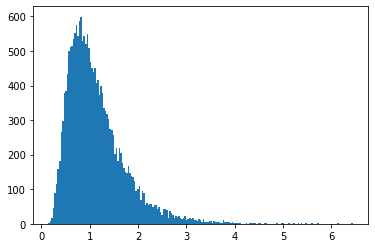

In [4]:
bins_num = 200 # número de bins a ser considerado
interval = np.linspace(np.min(data), np.max(data), bins_num)
plt.hist(data, bins=interval);

In [5]:
s2 = np.var(data)
s = np.std(data)
x = np.mean(data)
values, bins_val = np.histogram(data, bins = interval)
print('Média: ', x, ' Desvio: ', s, ' Variância: ', s2)

Média:  1.1337803041364507  Desvio:  0.6002883416927292  Variância:  0.3603460931722067


### Teste da distribuição Normal:

$\left\{\begin{array}{l} H_0:\ O_i = E_i \\ H_1:\ O_i \neq E_i  \end{array}\right.$

Considere:
$\chi^2$ = $\sum_{i=1}^{n}$ $\frac{(O_{i} - E_{i})^2}{(E_{i})}$.

Rejeita-se a hipótese nula se: $\chi^2$ > $\chi^2_{\alpha,\ n-p-1}$, onde $\alpha$ é o nível de significância, $n$ é o número de intervalos observados (bins) e $p$ é o número de parâmetros estimados na distribuição.

Hipótese nula rejeitada pois chi2 (631568.45) > chi2_teste (165.53)


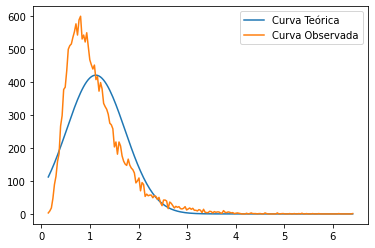

In [6]:
alpha = 0.05 # nível de signficância do teste

# distribuição normal teórica dos dados: 
dist_normal = stats.norm(loc=x, scale=s)
norm_cdf = dist_normal.cdf(interval)
area_bins_norm = norm_cdf[1:] - norm_cdf[:-1]
frequencia_teorica_norm = area_bins_norm * data.shape[0]

# teste:
chi2_norm = 0
for i in range(len(frequencia_teorica_norm)):
    if frequencia_teorica_norm[i] > 0.00001:
        chi2_norm += ((frequencia_teorica_norm[i] - values[i])**2/frequencia_teorica_norm[i])
    else:
        chi2_norm += 0
chi2_teste_norm = stats.chi2.ppf(alpha, df=bins_num-2-1) # = 239.8774290531936; bins=200
if chi2_norm < chi2_teste_norm  :
  print(f'Hipótese nula NÃO rejeitada pois chi2 ({chi2_norm:.2f}) < chi2_teste ({chi2_teste_norm:.2f})')
else:
  print(f'Hipótese nula rejeitada pois chi2 ({chi2_norm:.2f}) > chi2_teste ({chi2_teste_norm:.2f})')

# gráfico:
plt.plot(bins_val[:-1], frequencia_teorica_norm, label='Curva Teórica')
plt.plot(bins_val[:-1], values, label='Curva Observada')
plt.legend();

### Teste da distribuição Gamma:

$\left\{\begin{array}{l} H_0:\ O_i = E_i \\ H_1:\ O_i \neq E_i  \end{array}\right.$

Considere:
$\chi^2$ = $\sum_{i=1}^{n}$ $\frac{(O_{i} - E_{i})^2}{(E_{i})}$.

Rejeita-se a hipótese nula se: $\chi^2$ > $\chi^2_{\alpha,\ n-p-1}$, onde $\alpha$ é o nível de significância, $n$ é o número de intervalos observados (bins) e $p$ é o número de parâmetros estimados na distribuição.

Hipótese nula rejeitada pois chi2 (1848.02) > chi2_teste (165.53)


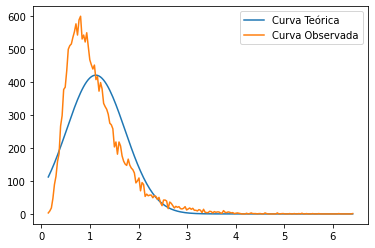

In [7]:
fit_shape, fit_loc, fit_scale = stats.gamma.fit(data)
dist_gamma = stats.gamma(a=fit_shape, loc=fit_loc, scale=fit_scale)
gamma_cdf = dist_gamma.cdf(interval)
area_bins_gamma = gamma_cdf[1:] - gamma_cdf[:-1]
frequencia_teorica_gamma = area_bins_gamma * data.shape[0]

# teste:
chi2_gamma = np.sum((values - frequencia_teorica_gamma)**2/frequencia_teorica_gamma) # = 212.6268094321364; bins=200
chi2_teste_gamma = stats.chi2.ppf(alpha, df=bins_num-2-1) # = 239.8774290531936; bins=200
if chi2_gamma < chi2_teste_gamma  :
  print(f'Hipótese nula NÃO rejeitada pois chi2 ({chi2_gamma:.2f}) < chi2_teste ({chi2_teste_gamma:.2f})')
else:
  print(f'Hipótese nula rejeitada pois chi2 ({chi2_gamma:.2f}) > chi2_teste ({chi2_teste_gamma:.2f})')

plt.plot(bins_val[:-1], frequencia_teorica_norm, label='Curva Teórica')
plt.plot(bins_val[:-1], values, label='Curva Observada')
plt.legend();

### Teste da distribuição LogNormal:

$\left\{\begin{array}{l} H_0:\ O_i = E_i \\ H_1:\ O_i \neq E_i  \end{array}\right.$

Considere:
$\chi^2$ = $\sum_{i=1}^{n}$ $\frac{(O_{i} - E_{i})^2}{(E_{i})}$.

Rejeita-se a hipótese nula se: $\chi^2$ > $\chi^2_{\alpha,\ n-p-1}$, onde $\alpha$ é o nível de significância, $n$ é o número de intervalos observados (bins) e $p$ é o número de parâmetros estimados na distribuição.


Hipótese nula NÃO rejeitada pois chi2 (212.61) < chi2_teste (230.75)


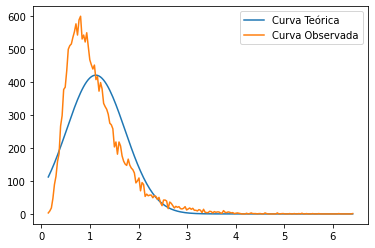

In [8]:
# Parâmetros de entrada stats.lognorm(s, loc, scale) explicados:
# loc - No equivalent, this gets subtracted from your data so that 0 becomes the infimum of the range of the data.
# scale - exp μ, where μ is the mean of the log of the variate. (When fitting, typically you'd use the sample mean of the log of the data.)
# s -> shape - the standard deviation of the log of the variate.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
# https://stackoverflow.com/questions/8870982/how-do-i-get-a-lognormal-distribution-in-python-with-mu-and-sigma?noredirect=1&lq=1

alpha = 0.95 # nível de signficância do teste
x_log = np.mean(np.log(data))  # média do logaritmo dos dados
s_log = np.std(np.log(data))  # desvio padrão do logaritmo dos dados

# distribuição lognormal teórica dos dados: 
dist_log_normal = stats.lognorm(s=s_log, loc=x_log, scale=np.exp(x_log))
log_cdf = dist_log_normal.cdf(interval)
area_bins = log_cdf[1:] - log_cdf[:-1]
frequencia_teorica = area_bins * data.shape[0]

# teste:
chi2_log = np.sum((values - frequencia_teorica)**2/frequencia_teorica) # = 212.6268094321364; bins=200
chi2_teste_log = stats.chi2.ppf(alpha, df=bins_num-2-1) # = 239.8774290531936; bins=200
if chi2_log < chi2_teste_log  :
  print(f'Hipótese nula NÃO rejeitada pois chi2 ({chi2_log:.2f}) < chi2_teste ({chi2_teste_log:.2f})')
else:
  print(f'Hipótese nula rejeitada pois chi2 ({chi2_log:.2f}) > chi2_teste ({chi2_teste_log:.2f})')

# gráfico:
plt.plot(bins_val[:-1], frequencia_teorica_norm, label='Curva Teórica')
plt.plot(bins_val[:-1], values, label='Curva Observada')
plt.legend();

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.012351,862.017588,-285920.356893,inf,0.005506,5.771556e-01
gamma,0.063017,1058.486056,-253326.911849,inf,0.022316,4.387079e-09
norm,1.115995,2292.203863,-195855.024860,inf,0.095984,7.981819e-161
expon,3.902555,636.882408,-170817.317072,inf,0.221662,0.000000e+00


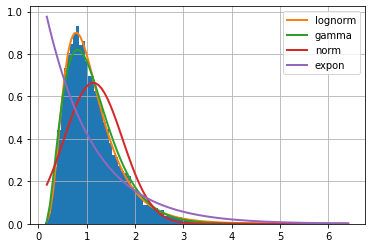

In [9]:
f = Fitter(data,distributions=['gamma','lognorm',"norm", "expon"])
f.fit()
f.summary()

In [10]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.5024856117097087,
  'loc': 0.0018064678639005275,
  'scale': 0.9982167988693524}}

- Dessa forma, chega-se à conclusão que a distribuição que melhor se adapta aos dados fornecidos é a lognormal.

### EXTRA: Função que testa várias distribuições

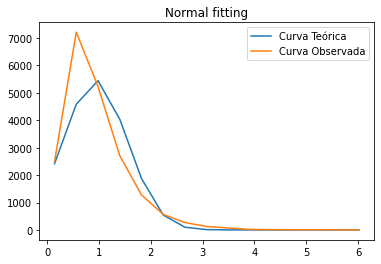

O teste para a distribuição Normal rejeita a hipótese nula, chi = 901925001344.09, chi_teste = 21.03.


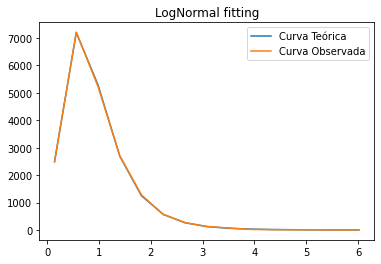

O teste para a distribuição LogNormal NÃO rejeita a hipótese nula, chi = 12.17, chi_teste = 21.03.


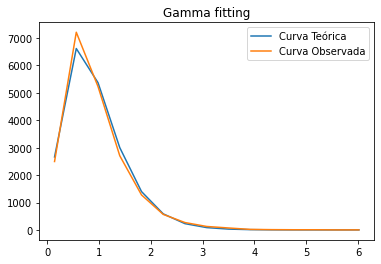

O teste para a distribuição Gamma rejeita a hipótese nula, chi = 416.27, chi_teste = 21.03.


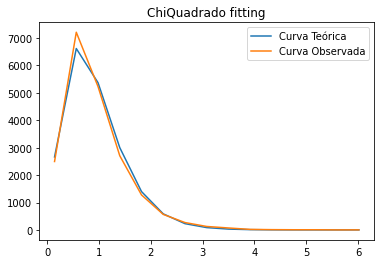

O teste para a distribuição ChiQuadrado rejeita a hipótese nula, chi = 416.32, chi_teste = 21.03.


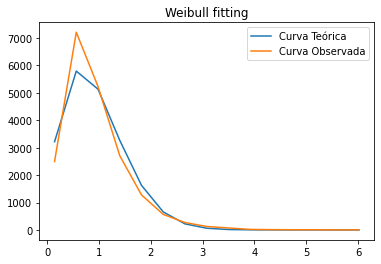

O teste para a distribuição weibull_min rejeita a hipótese nula, chi = 39995.17, chi_teste = 21.03.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

def plots(frequencia_teorica, histogram, bins_val, kind):
    plt.plot(bins_val[:-1], frequencia_teorica, label='Curva Teórica')
    plt.plot(bins_val[:-1], histogram, label='Curva Observada')
    plt.legend()
    plt.title(f'{kind} fitting')
    plt.show()


def normal_test(data, histogram, bins_val, bins_num, alpha, show_hist=False):
    fit_loc, fit_scale = stats.norm.fit(data)
    dist = stats.norm(loc=fit_loc, scale=fit_scale)
    values = dist.cdf(bins_val)
    area_bins = values[1:] - values[:-1]
    frequencia_teorica = area_bins * data.shape[0]
    chi2 =  np.sum((histogram - frequencia_teorica)**2/frequencia_teorica, where=frequencia_teorica!=0)
    chi2_teste = stats.chi2.ppf(1-alpha, df=bins_num-2-1)
    if show_hist:
        plots(frequencia_teorica, histogram, bins_val, 'Normal')
    return f'O teste para a distribuição Normal {"NÃO " if chi2 < chi2_teste else ""}rejeita a hipótese nula, chi = {chi2:.2f}, chi_teste = {chi2_teste:.2f}.'

def chi2_test(data, histogram, bins_val, bins_num, alpha, show_hist=False):
    fit_shape, fit_loc, fit_scale = stats.chi2.fit(data)
    dist = stats.chi2(df=fit_shape, loc=fit_loc, scale=fit_scale)
    values = dist.cdf(bins_val)
    area_bins = values[1:] - values[:-1]
    frequencia_teorica = area_bins * data.shape[0]
    chi2 =  np.sum((histogram - frequencia_teorica)**2/frequencia_teorica, where=frequencia_teorica!=0)
    chi2_teste = stats.chi2.ppf(1-alpha, df=bins_num-2-1)
    if show_hist:
        plots(frequencia_teorica, histogram, bins_val, 'ChiQuadrado')   
    return f'O teste para a distribuição ChiQuadrado {"NÃO " if chi2 < chi2_teste else ""}rejeita a hipótese nula, chi = {chi2:.2f}, chi_teste = {chi2_teste:.2f}.'

def gamma_test(data, histogram, bins_val, bins_num, alpha, show_hist=False):
    fit_shape, fit_loc, fit_scale = stats.gamma.fit(data)
    dist = stats.gamma(a=fit_shape, loc=fit_loc, scale=fit_scale)
    values = dist.cdf(bins_val)
    area_bins = values[1:] - values[:-1]
    frequencia_teorica = area_bins * data.shape[0]
    chi2 =  np.sum((histogram - frequencia_teorica)**2/frequencia_teorica, where=frequencia_teorica!=0)
    chi2_teste = stats.chi2.ppf(1-alpha, df=bins_num-2-1) 
    if show_hist:
        plots(frequencia_teorica, histogram, bins_val, 'Gamma')
    return f'O teste para a distribuição Gamma {"NÃO " if chi2 < chi2_teste else ""}rejeita a hipótese nula, chi = {chi2:.2f}, chi_teste = {chi2_teste:.2f}.'

def log_normal_test(data, histogram, bins_val, bins_num, alpha, show_hist=False):
    fit_shape, fit_loc, fit_scale = stats.lognorm.fit(data)
    dist = stats.lognorm(s=fit_shape, loc=fit_loc, scale=fit_scale)
    values = dist.cdf(bins_val)
    area_bins = values[1:] - values[:-1]
    frequencia_teorica = area_bins * data.shape[0]
    chi2 =  np.sum((histogram - frequencia_teorica)**2/frequencia_teorica, where=frequencia_teorica!=0)
    chi2_teste = stats.chi2.ppf(1-alpha, df=bins_num-2-1) 
    if show_hist:
        plots(frequencia_teorica, histogram, bins_val, 'LogNormal')
    return f'O teste para a distribuição LogNormal {"NÃO " if chi2 < chi2_teste else ""}rejeita a hipótese nula, chi = {chi2:.2f}, chi_teste = {chi2_teste:.2f}.'

def weibull_test(data, histogram, bins_val, bins_num, alpha, show_hist=False):
    fit_shape, fit_loc, fit_scale = stats.weibull_min.fit(data)
    dist = stats.weibull_min(c=fit_shape, loc=fit_loc, scale=fit_scale)
    values = dist.cdf(bins_val)
    area_bins = values[1:] - values[:-1]
    frequencia_teorica = area_bins * data.shape[0]
    chi2 =  np.sum((histogram - frequencia_teorica)**2/frequencia_teorica, where=frequencia_teorica!=0)
    chi2_teste = stats.chi2.ppf(1-alpha, df=bins_num-2-1) 
    if show_hist:
        plots(frequencia_teorica, histogram, bins_val, 'Weibull')
    return f'O teste para a distribuição weibull_min {"NÃO " if chi2 < chi2_teste else ""}rejeita a hipótese nula, chi = {chi2:.2f}, chi_teste = {chi2_teste:.2f}.'

def goodness_of_fit(data, bins_num, alpha, show_hist=False):
    distributions = [normal_test, log_normal_test, gamma_test, chi2_test, weibull_test]
    histogram, bins_val = np.histogram(data, bins = bins_num)
    for dist in distributions:
        print(dist(data, histogram, bins_val, bins_num=bins_num, alpha=alpha, show_hist=show_hist))


data = np.load('values_squad1.npy')
goodness_of_fit(data=data, bins_num=15, alpha=0.05, show_hist=True)

________
Q3 - SERIES TEMPORAIS
____

In [12]:
df_energia = pd.read_csv('ipeadata_consumo_energia.csv', sep=';')
df_energia = df_energia.drop(columns='Unnamed: 2')
df_energia = df_energia.rename(columns={'Energia elétrica - consumo - residência - quantidade - GWh - Eletrobras - ELETRO12_CEERES12':'Consumo'})
df_energia['Consumo'] = df_energia['Consumo'].apply(lambda x: x.replace(',','.'))
df_energia['Data'] = df_energia['Data'].apply(lambda x: str(x).replace('.','-'))

In [13]:
df_energia['Data'] = pd.to_datetime(df_energia['Data'], format='%Y-%m')
df_energia['Consumo'] = df_energia['Consumo'].astype('float')

rng = pd.date_range(start = '1976-01-01', end = '2022-07-01', freq='MS')
rng = pd.DataFrame(rng)
df_energia.loc[:,['Data']] = [rng]

df_energia = df_energia.set_index('Data')

In [14]:
series = df_energia['Consumo']


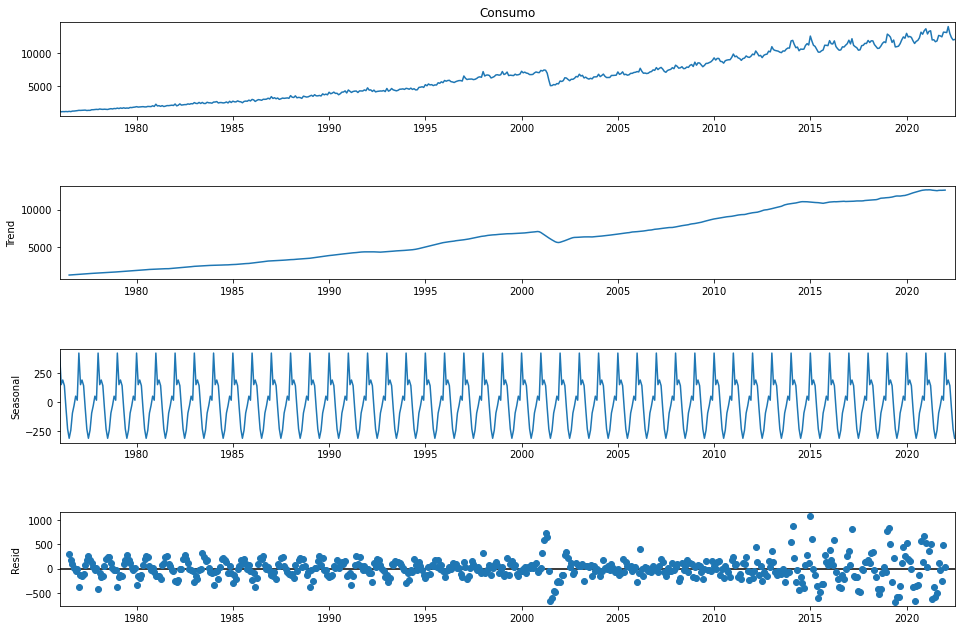

In [15]:
result = seasonal_decompose(series, model='additive')
fig = result.plot()
fig.set_size_inches((15, 10))
plt.show()

Observando o gráfico acima, podemos observar que o consumo de energia elétrica em GWh no Brasil vem crescendo ao longo dos anos, o que é ressaltado pelo gráfico da tendência. Também é possível observar a presença de uma sazonalidade com amplitude por volta de 280 GWh. Além disso, vemos que há cinco períodos de sazonaliodades completos em um período de 5 anos (repare no gráfico de sazonalidade de 1985 a 1990, por exemplo), logo há uma sazonalidade anual. Por fim, vê-se que os resíduos se comportam de maneira similar, excetuando períodos com maiores oscilações, provavelmente em razão de motivos de infraestrutura, macro e microeconômicos. É interessante ver que os períodos com maiores resíduos são aqueles com maiores oscilações de consumo, o que, no caso, é um resultado direto da oscilação, então seria esperado.\
Os períodos com maiores oscilações, citados acima, seriam os períodos atípicos perguntados no enunciado. Especificamente na época de 2001-2002, ocorreu um racionamento de energia no Brasil, conhecido como apagão, em razão da falta de chuvas. Dessa forma, o governo orientou tal racionamento para que não ocorresse outro apagão total de energia como se passou em alguns dias daqueles anos.

In [16]:
valor_max = df_energia['Consumo'].max()
periodo_max = df_energia[df_energia['Consumo'] == valor_max].index

valor_min = df_energia['Consumo'].min()
periodo_min = df_energia[df_energia['Consumo'] == valor_min].index

In [17]:
print(f'O consumo máximo foi de {valor_max} GWh e ocorreu em {str(periodo_max[0])[0:7]}. \
Já o consumo mínimo foi de {valor_min} GWh e ocorreu em {str(periodo_min[0])[0:7]}.')

O consumo máximo foi de 13926.0 GWh e ocorreu em 2022-03. Já o consumo mínimo foi de 1161.6 GWh e ocorreu em 1976-02.


Agora, vejamos com mais detalhes um período de 3 anos para ver a sazonalidade

In [18]:
ano_inicial_corte = 2015
ano_final_corte = 2018
series2 = df_energia['Consumo'][12*(ano_inicial_corte-1976):12*(ano_final_corte-1976)+12]

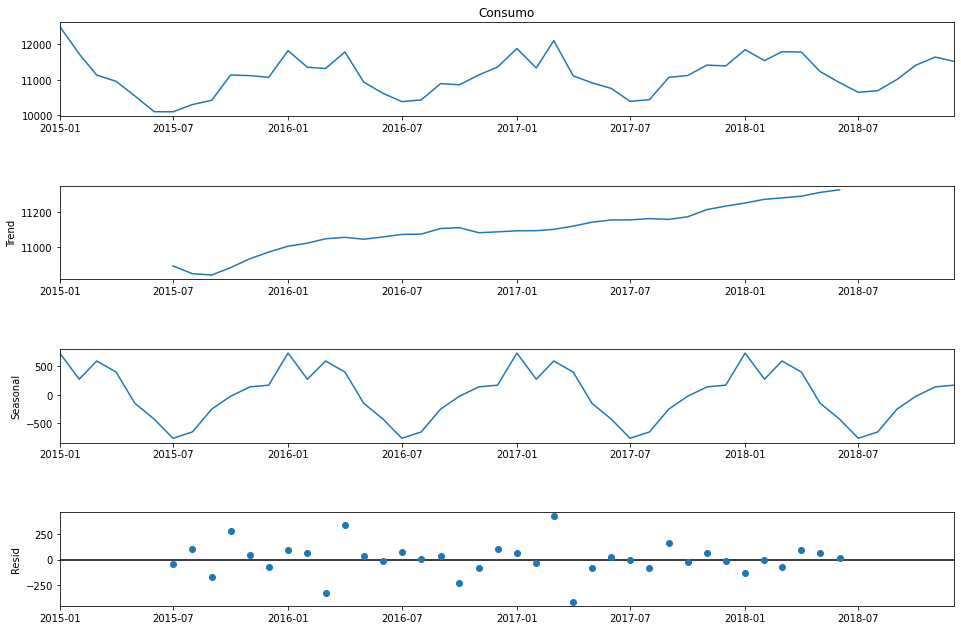

In [19]:
result2 = seasonal_decompose(series2, model='additive')
fig = result2.plot()
fig.set_size_inches((15, 10))
plt.show()

Com os gráficos acima, pode-se observar que o pico de consumo de energia ocorre sempre no mês de janeiro daquele ano, o que coincide com o verão, possivelmente um dos meses mais quentes do ano e que também possui diversos eventos associados que podem aumentar o consumo de energia, tal como festas de fim de ano. Além disso, o vale de consumo ocorre em julho, mês de inverno, quando não é necessário utilizar diversos aparelhos domésticos que consomem energia como ar-condicionado.

Agora, vejamos o consumo de energia no período de 2000 a 2002

In [20]:
ano_inicial_corte = 2000
ano_final_corte = 2002
series3 = df_energia['Consumo'][12*(ano_inicial_corte-1976):12*(ano_final_corte-1976)+12]


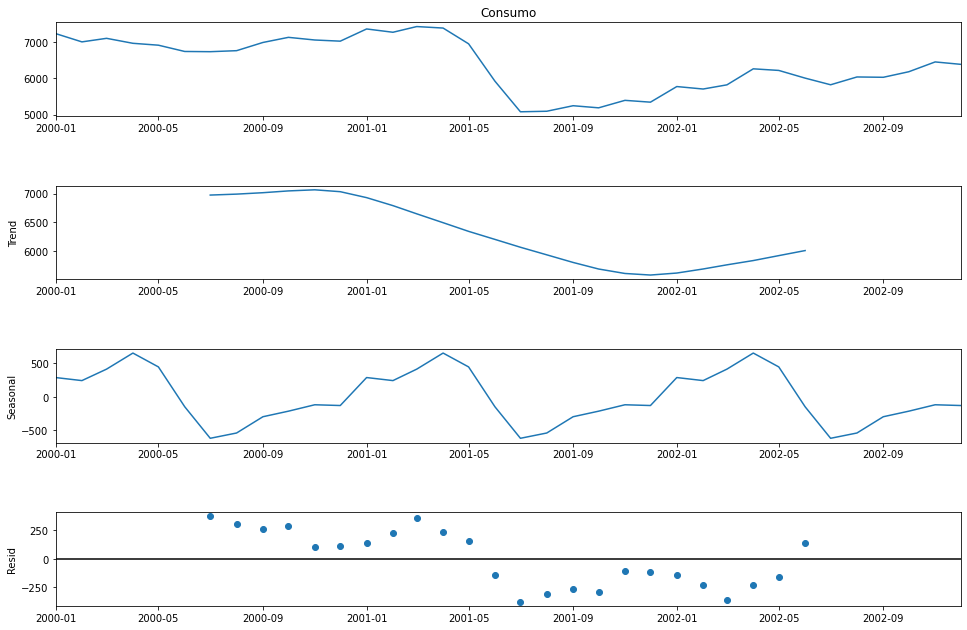

In [21]:
result3 = seasonal_decompose(series3, model='additive')
fig = result3.plot()
fig.set_size_inches((15, 10))
plt.show()

Pode-se observar o efeito do apagão de 2001 por volta do mês de maio desse ano, que fez com que o consumo caísse de 7000 GWh a 5000 GWh em pouco tempo. Esse fato foi tão significativo que faz com que a sazonalidade do consumo seja alterada quando analisa-se uma janela temporal focada nesse evento.

##### Resíduos da série

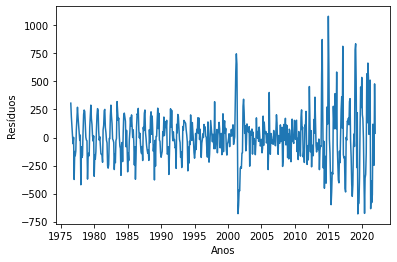

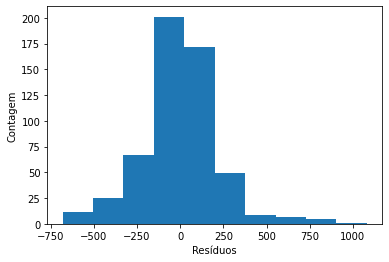

In [22]:
residual = result.resid
residual= residual.dropna()
plt.plot(residual, label='Residuals');
plt.xlabel('Anos'); plt.ylabel('Resíduos')

plt.figure()
bins_num = 10
plt.hist(residual, bins = bins_num);
plt.xlabel('Resíduos'); plt.ylabel('Contagem');

Hipótese nula rejeitada pois chi2 (146.61) > chi2_teste (14.07)


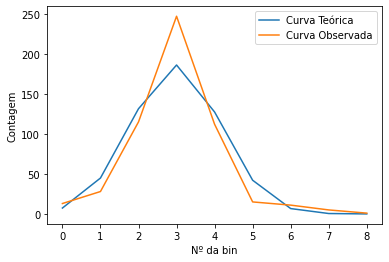

In [23]:
residual = np.array(residual)

x = np.mean(residual)
s = np.std(residual)
interval = np.linspace(np.min(residual), np.max(residual), bins_num)
values, bins_val = np.histogram(residual, bins = interval)

alpha = 0.05 # nível de signficância do teste

# distribuição normal teórica dos dados: 
dist_normal = stats.norm(loc=x, scale=s)
norm_cdf = dist_normal.cdf(interval)
area_bins_norm = norm_cdf[1:] - norm_cdf[:-1]
frequencia_teorica_norm = area_bins_norm * residual.shape[0]

# teste:
chi2_norm = 0
for i in range(len(frequencia_teorica_norm)):
    if frequencia_teorica_norm[i] > 0.00001:
        chi2_norm += ((frequencia_teorica_norm[i] - values[i])**2/frequencia_teorica_norm[i])
    else:
        chi2_norm += 0
chi2_teste_norm = stats.chi2.ppf(1-alpha, df=bins_num-2-1) # = 239.8774290531936; bins=200
if chi2_norm < chi2_teste_norm  :
  print(f'Hipótese nula NÃO rejeitada pois chi2 ({chi2_norm:.2f}) < chi2_teste ({chi2_teste_norm:.2f})')
else:
  print(f'Hipótese nula rejeitada pois chi2 ({chi2_norm:.2f}) > chi2_teste ({chi2_teste_norm:.2f})')

# gráfico:
plt.plot(frequencia_teorica_norm, label='Curva Teórica')
plt.plot(values, label='Curva Observada')
plt.xlabel('Nº da bin'); plt.ylabel('Contagem')
plt.legend();

In [24]:
from statsmodels.graphics.gofplots import qqplot

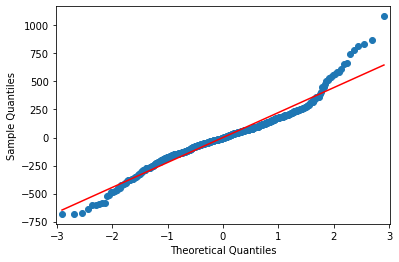

In [25]:
qqplot(residual, line = 's')
plt.show;

Pelo teste acima, não foi possível aceitar a hipótese que a distribuição dos resíduos é normal. Podemos testar se os eventos que causaram grandes oscilações no consumo de energia estão influenciando nessa não normalidade dos resultados. Assim, o teste de hipótese a seguir é feito de 1976 a 1996.

Text(0, 0.5, 'Contagem')

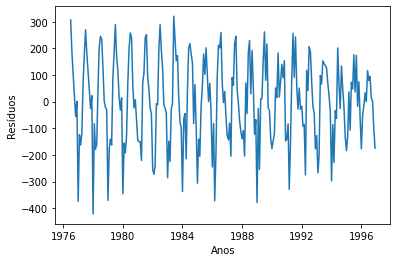

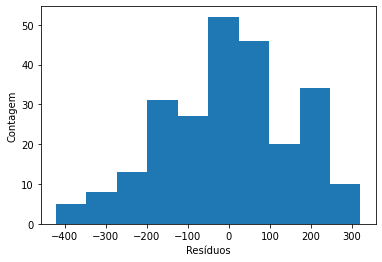

In [26]:
residual = result.resid
residual= residual[0:12*21].dropna()
plt.plot(residual, label='Residuals');
plt.xlabel('Anos'); plt.ylabel('Resíduos')

bins_num = 10
plt.figure()
plt.hist(residual, bins = bins_num);
plt.xlabel('Resíduos'); plt.ylabel('Contagem')

Hipótese nula NÃO rejeitada pois chi2 (9.38) < chi2_teste (14.07)


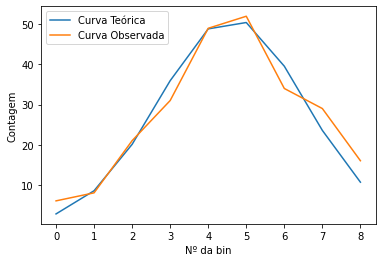

In [27]:
residual = np.array(residual)

x = np.mean(residual)
s = np.std(residual)
interval = np.linspace(np.min(residual), np.max(residual), bins_num)
values, bins_val = np.histogram(residual, bins = interval)

alpha = 0.05 # nível de signficância do teste

# distribuição normal teórica dos dados: 
dist_normal = stats.norm(loc=x, scale=s)
norm_cdf = dist_normal.cdf(interval)
area_bins_norm = norm_cdf[1:] - norm_cdf[:-1]
frequencia_teorica_norm = area_bins_norm * residual.shape[0]

# teste:
chi2_norm = 0
for i in range(len(frequencia_teorica_norm)):
    if frequencia_teorica_norm[i] > 0.00001:
        chi2_norm += ((frequencia_teorica_norm[i] - values[i])**2/frequencia_teorica_norm[i])
    else:
        chi2_norm += 0
chi2_teste_norm = stats.chi2.ppf(1-alpha, df=bins_num-2-1) # = 239.8774290531936; bins=200
if chi2_norm < chi2_teste_norm  :
  print(f'Hipótese nula NÃO rejeitada pois chi2 ({chi2_norm:.2f}) < chi2_teste ({chi2_teste_norm:.2f})')
else:
  print(f'Hipótese nula rejeitada pois chi2 ({chi2_norm:.2f}) > chi2_teste ({chi2_teste_norm:.2f})')

# gráfico:
plt.plot(frequencia_teorica_norm, label='Curva Teórica')
plt.plot(values, label='Curva Observada')
plt.xlabel('Nº da bin'); plt.ylabel('Contagem')
plt.legend();

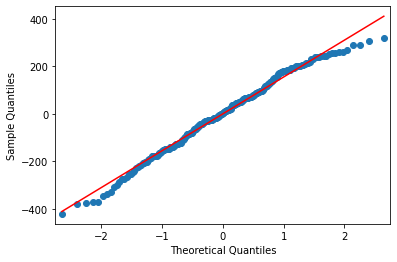

In [28]:
qqplot(residual, line = 's')
plt.show;

Neste caso, para as condições analisadas, temos que não podemos rejeitar a hipótese nula, indicando que os desvios tendem a uma normalidade.

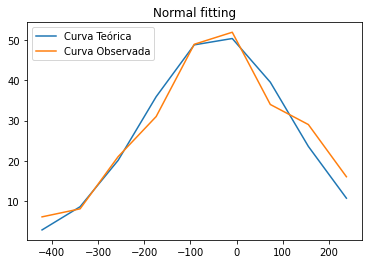

O teste para a distribuição Normal NÃO rejeita a hipótese nula, chi = 9.38, chi_teste = 12.59.


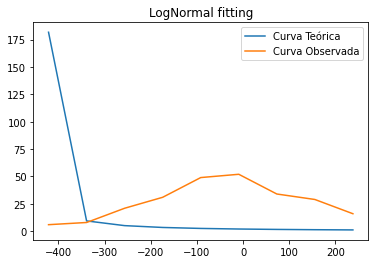

O teste para a distribuição LogNormal rejeita a hipótese nula, chi = 3835.94, chi_teste = 12.59.


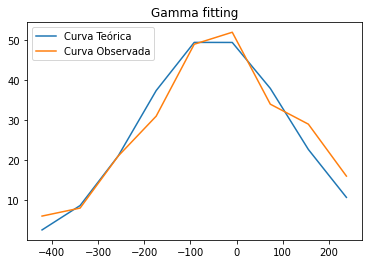

O teste para a distribuição Gamma NÃO rejeita a hipótese nula, chi = 10.85, chi_teste = 12.59.


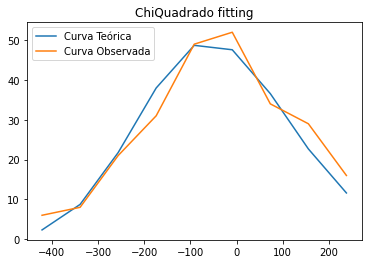

O teste para a distribuição ChiQuadrado NÃO rejeita a hipótese nula, chi = 11.23, chi_teste = 12.59.


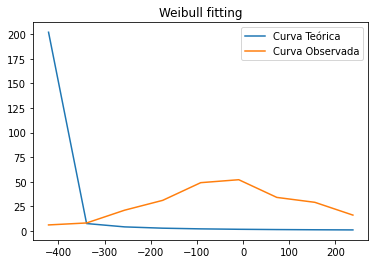

O teste para a distribuição weibull_min rejeita a hipótese nula, chi = 5105.92, chi_teste = 12.59.


In [29]:
goodness_of_fit(data=residual, bins_num=9, alpha=0.05, show_hist=True)